In [1]:
import sys
#sys.path.append("C://Users//RDBanjacJe//Desktop//ELMToolBox") 
sys.path.append("../..") 
from microbiome.data_preparation import *
from microbiome.trajectory import *
from microbiome.postprocessing import *
from microbiome.statistical_analysis import *

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import GroupKFold
from scipy.stats import pearsonr
import shap
import scipy as sp
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold
from skbio.stats.composition import clr
import itertools
from matplotlib.lines import Line2D
import statsmodels.api as sm
import math
#from scipy import stats
import scipy
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
from catboost import Pool
import pathlib

pd.options.display.max_columns = None
pd.options.display.max_rows    = None
pd.options.display.max_colwidth = None

In [3]:
DATASET_LEVEL = "genus"
SAVE_IDENTIFIER = "mouse_data"
save = True

n_splits = 3
test_size = 0.5
limit_age=99999
start_age=0

PIPELINE_DIRECTORY = f"OUTPUT_FILES/{DATASET_LEVEL}_{SAVE_IDENTIFIER}"
pathlib.Path(f"{PIPELINE_DIRECTORY}/images").mkdir(parents=True, exist_ok=True)

In [4]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

---

In [5]:
Regressor = CatBoostRegressor
parameters = {"loss_function": "MAE",
              "random_state": 42,
              "allow_writing_files": True,
             "verbose":False}
param_grid = { 'learning_rate': [0.5, 0.1],
               #"depth": [5, 10],
               #"iterations": [100, 500, 1000]
             }

In [6]:
df = pd.read_csv("INPUT_FILES/mousedata.xls", sep="\t")
df = df.rename({"relativeTime":"age_at_collection", "mouseID":"subjectID"}, axis=1)
#df = df.drop(columns=["EBFmin3months", "EBFmin4months"])

# selected
#df = df[~df.gid_wgs.isna()]

# fill nan values with mean
df = df.fillna(df.mean())

df = df.convert_dtypes() 

id_cols = df.columns[df.columns.str.contains("id", case=False)&(df.columns.str.len()<20)]
print("ID columns:      ", list(id_cols))

# convert cathegorical values to dummies
str_cols = list(set(df.columns[df.dtypes=="string"]) - set(id_cols))
df = pd.get_dummies(df, columns=str_cols)
print("string columns:  ", list(str_cols))

# convert bool columns to integers
bool_cols = df.columns[df.dtypes=="boolean"]
print("boolean columns: ", list(bool_cols))
df[bool_cols] = df[bool_cols].astype(float) 

# convert int columns to float
int_cols = list(set(df.columns[df.dtypes=="Int64"])-set(id_cols))
print("integer columns: ", list(int_cols))
df[int_cols] = df[int_cols].astype(float)  

print(df.shape)
df.head()

ID columns:       ['sampleID', 'g__Bacteroides', 'g__Clostridium', 'g__Parabacteroides', 'subjectID']
string columns:   ['date', 'diet']
boolean columns:  []
integer columns:  ['age_at_collection', 'status']
(137, 53)


sampleID  g__Akkermansia  g__Alistipes  g__Anaerofilum  \
0  PM1:20080108        5.198270      8.861973             0.0   
1  PM1:20080114        8.163470      8.685500             0.0   
2  PM1:20071211        8.536715      6.230243             0.0   
3  PM1:20080121        6.658211      8.647458             0.0   
4  PM1:20071217        0.000000      9.300649             0.0   

   g__Anaerofustis  g__Anaerostipes  g__Anaerotruncus  g__Anaerovorax  \
0         0.000000         6.178487          6.178487        5.198270   
1         0.000000         5.198270          6.496426        0.000000   
2         0.000000         6.230243          0.000000        0.000000   
3         0.000000         6.658211          5.101538        5.101538   
4         5.249333         5.249333          5.249333        0.000000   

   g__Bacteroides  g__Bilophila  g__Bryantella  g__Clostridium  \
0       13.537929      0.000000       7.971544        0.000000   
1       14.011826      6.178487       8.916306        0.000000   
2       12.998976      0.000000       0.000000        9.213329   
3       14.394351      6.080373       8.968667        0.000000   
4       13.803455      8.215758       5.249333        0.000000   

   g__Collinsella  g__Coprobacillus   g__Dorea  g__Eggerthella  \
0        5.198270         11.462721   6.178487        0.000000   
1        4.237039          9.887873   5.198270        4.237039   
2       10.341292          7.540594   7.802337        5.249333   
3        0.000000         11.103943   6.658211        0.000000   
4        0.000000          9.912834  11.255881        0.000000   

   g__Enterobacter  g__Enterococcus  g__ErysipelotrichaceaeIncertaeSedis  \
0         0.000000              0.0                             9.482376   
1         0.000000              0.0                             9.068010   
2         9.213329              0.0                            10.671213   
3         0.000000              0.0                             9.231221   
4         0.000000              0.0                             6.808785   

   g__Eubacterium  g__Faecalibacterium  g__Hespellia  g__Holdemania  \
0        7.750109            11.886731      0.000000       6.178487   
1        5.198270             9.887873      0.000000       0.000000   
2        6.230243             7.220602      0.000000       5.249333   
3        7.389452            10.787631      5.101538       5.101538   
4        0.000000            13.415600      0.000000       0.000000   

   g__Hydrogenophaga  g__LachnospiraceaeIncertaeSedis  g__Lactococcus  \
0                0.0                        12.559548             0.0   
1                0.0                        11.525241             0.0   
2                0.0                        11.811211             0.0   
3                0.0                        12.136030             0.0   
4                0.0                        11.811211             0.0   

   g__Mogibacterium     g__nan  g__Parabacteroides  g__Prevotella  \
0               0.0  14.360622           10.713877      14.109796   
1               0.0  14.508325           11.041757       8.163470   
2               0.0  14.468348           11.044470      13.395906   
3               0.0  14.971828           10.942270      11.451726   
4               0.0  14.718745           12.505766      15.998821   

   g__Roseburia  g__RuminococcaceaeIncertaeSedis  g__Ruminococcus  \
0      0.000000                         7.488414         7.750109   
1      0.000000                         6.756795         9.408481   
2      6.230243                         7.220602         0.000000   
3      0.000000                         7.872418         9.382984   
4      0.000000                         7.220602         8.023806   

   g__Subdoligranulum  g__Sutterella  g__Turicibacter subjectID  \
0            0.000000       0.000000         0.000000       PM1   
1            0.000000       4.237039         0.000000       PM1   
2            6.230243       5

In [7]:
df["diet_BK"] = df["diet_BK"].astype("string")
df["diet_BK"].dtype

StringDtype

In [8]:
# bacteria_unknown = df.columns[df.columns.str.endswith("g__")]
# print(f"Number of unknown bacteria: {len(bacteria_unknown)}")

# # put the sum of unkown bacteria to `Other`, but still save the individual with prefix `unknown_`
# bacteria_unknown_new_name = dict([ (b, f"unknown__{b}") for b in bacteria_unknown])
# df = df.rename(columns=bacteria_unknown_new_name)
# df["k__Other;p__Other;c__Other;o__Other;f__Other;g__Other"] = df.apply(lambda row: row[bacteria_unknown_new_name.values()].sum(), axis=1)

In [9]:
bacteria_names = sorted(list(df.columns[df.columns.str.startswith("g__")].values))
print(f"Number of bacteria names (+1 column with all unknown bacteria): {len(bacteria_names)}")

Number of bacteria names (+1 column with all unknown bacteria): 35


In [10]:
def fix_zeros(row):
    for c in bacteria_names:
        row[c] = 1e-10 if row[c]==0.0 or row[c]<1e-10 else row[c]
    return row

# put zeros and very small values to 1e-10 so ratios are better handled
df = df.apply(lambda row: fix_zeros(row), axis=1)

In [11]:
feature_cols = remove_nzv(save, df, bacteria_names, n_splits, estimator_for_fit= Regressor(**parameters), nzv_thresholds=np.arange(0, 10, 1))

Number of features left after removing features with variance 6 or smaller: 21/35


In [12]:
#_feature_cols = remove_correlated(save, df, _feature_cols, n_splits, estimator_for_fit=Regressor(**parameters), correlation_thresholds=np.arange(0, 1, 0.1))

In [13]:
#feature_cols = bacteria_names.copy()

---

## Prepare data

In [14]:
df_ref = df[df["status"]==1]  #df[df["diet_BK"]==1]
df_ref.shape

(69, 53)

In [15]:
df_other = df[~df["sampleID"].isin(df_ref["sampleID"])]
df_other.shape

(68, 53)

In [16]:
group_split_name = "subjectID"

In [17]:
shared_idx = list(set(df_ref["subjectID"]).intersection(set(df_other["subjectID"])))
ref_idx_only = list(set(df_ref["subjectID"]) - set(df_other["subjectID"]))
other_idx_only = list(set(df_other["subjectID"]) - set(df_ref["subjectID"]))

print(f"Shared subject IDs: {shared_idx}")
print(f"Reference subject IDs only: {ref_idx_only}")
print(f"Others subject IDs only: {other_idx_only}")

Shared subject IDs: []
Reference subject IDs only: ['PM6', 'PM9', 'PM5', 'PM10', 'PM8', 'PM12']
Others subject IDs only: ['PM7', 'PM11', 'PM1', 'PM2', 'PM4', 'PM3']


In [18]:
# share in half the subjectIDs that are shared between these 2 groups
df_shared_sid = df[df.subjectID.isin(shared_idx)]

if len(df_shared_sid) > 0:
    ref_shared_idx, other_shared_idx = next(GroupShuffleSplit(test_size=0.5, n_splits=2, random_state=7).split(df_shared_sid, groups=df_shared_sid["subjectID"]))

    df_ref_sid = pd.concat([df_shared_sid.iloc[ref_shared_idx], df[df.subjectID.isin(ref_idx_only)]])
    train_idx1, val_idx1 = next(GroupShuffleSplit(test_size=test_size, n_splits=2, random_state=7).split(df_ref_sid, groups=df_ref_sid["subjectID"]))

    df_other_sid = pd.concat([df_shared_sid.iloc[other_shared_idx], df[df.subjectID.isin(other_idx_only)]])
    train_idx2, val_idx2 = next(GroupShuffleSplit(test_size=test_size, n_splits=2, random_state=7).split(df_other_sid, groups=df_other_sid["subjectID"]))
    
    
else:
    df_ref_sid = df[df.subjectID.isin(ref_idx_only)]
    train_idx1, val_idx1 = next(GroupShuffleSplit(test_size=test_size, n_splits=2, random_state=7).split(df_ref_sid, groups=df_ref_sid["subjectID"]))
    
    df_other_sid = df[df.subjectID.isin(other_idx_only)]
    train_idx2, val_idx2 = next(GroupShuffleSplit(test_size=test_size, n_splits=2, random_state=7).split(df_other_sid, groups=df_other_sid["subjectID"]))

train1 = df_ref_sid.iloc[train_idx1]
val1   = df_ref_sid.iloc[val_idx1]
train2 = df_other_sid.iloc[train_idx2]
val2   = df_other_sid.iloc[val_idx2]

In [19]:
X_train1, y_train1 = df2vectors(train1, feature_cols)
X_val1, y_val1     = df2vectors(val1, feature_cols)
X_train2, y_train2 = df2vectors(train2, feature_cols)
X_val2, y_val2     = df2vectors(val2, feature_cols)

In [20]:
print(f"Total number of subject: {len(df.subjectID.unique())}")
print(f"--- Number of subject:   {len(train1.subjectID.unique())}")
print(f"Size of training features X_train1:    {X_train1.shape}")
print(f"Size of training labels y_train1:      {y_train1.shape}")
print(f"--- Number of subject:   {len(val1.subjectID.unique())}")
print(f"Size of validation features X_val1:    {X_val1.shape}")
print(f"Size of validation labels y_val1:      {y_val1.shape}")
print(f"--- Number of subject:   {len(train2.subjectID.unique())}")
print(f"Size of training features X_train2:    {X_train2.shape}")
print(f"Size of training labels y_train2:      {y_train2.shape}")
print(f"--- Number of subject:   {len(val2.subjectID.unique())}")
print(f"Size of validation features X_val2:    {X_val2.shape}")
print(f"Size of validation labels y_val2:      {y_val2.shape}")

Total number of subject: 12
--- Number of subject:   3
Size of training features X_train1:    (35, 21)
Size of training labels y_train1:      (35,)
--- Number of subject:   3
Size of validation features X_val1:    (34, 21)
Size of validation labels y_val1:      (34,)
--- Number of subject:   3
Size of training features X_train2:    (35, 21)
Size of training labels y_train2:      (35,)
--- Number of subject:   3
Size of validation features X_val2:    (33, 21)
Size of validation labels y_val2:      (33,)


In [21]:
train1.subjectID.unique(), val1.subjectID.unique()

(array(['PM12', 'PM5', 'PM8'], dtype=object),
 array(['PM10', 'PM6', 'PM9'], dtype=object))

In [22]:
train2.subjectID.unique(), val2.subjectID.unique()

(array(['PM11', 'PM2', 'PM4'], dtype=object),
 array(['PM1', 'PM3', 'PM7'], dtype=object))

### Baseline for Validation Dataset

In [23]:
y_baseline = val1["age_at_collection"].mean()

# Print out the mean absolute error (mae)
print(f'MAE: {round(np.mean(abs(y_baseline - y_val1)), 2)} days')

MAE: 19.18 days


In [24]:
rfr = Regressor(**parameters)
gkf = list(GroupKFold(n_splits=n_splits).split(X_train1, y_train1, groups=train1["subjectID"].values))

search = GridSearchCV(rfr, param_grid, cv=gkf)
search.fit(X_train1, y_train1)

estimator = search.best_estimator_
estimator.save_model(f"{PIPELINE_DIRECTORY}/model_NoTopImportant")

In [25]:
val1.columns

Index(['sampleID', 'g__Akkermansia', 'g__Alistipes', 'g__Anaerofilum',
       'g__Anaerofustis', 'g__Anaerostipes', 'g__Anaerotruncus',
       'g__Anaerovorax', 'g__Bacteroides', 'g__Bilophila', 'g__Bryantella',
       'g__Clostridium', 'g__Collinsella', 'g__Coprobacillus', 'g__Dorea',
       'g__Eggerthella', 'g__Enterobacter', 'g__Enterococcus',
       'g__ErysipelotrichaceaeIncertaeSedis', 'g__Eubacterium',
       'g__Faecalibacterium', 'g__Hespellia', 'g__Holdemania',
       'g__Hydrogenophaga', 'g__LachnospiraceaeIncertaeSedis',
       'g__Lactococcus', 'g__Mogibacterium', 'g__nan', 'g__Parabacteroides',
       'g__Prevotella', 'g__Roseburia', 'g__RuminococcaceaeIncertaeSedis',
       'g__Ruminococcus', 'g__Subdoligranulum', 'g__Sutterella',
       'g__Turicibacter', 'subjectID', 'age_at_collection', 'status',
       'date_2007-12-11', 'date_2007-12-17', 'date_2008-01-07',
       'date_2008-01-08', 'date_2008-01-14', 'date_2008-01-21',
       'date_2008-01-28', 'date_2008-02-04', 

In [26]:
val1.loc[:, "group"] = sum([val1[x].astype(int) for x in val1.columns[val1.columns.str.startswith("date_2007")|val1.columns.str.startswith("date_2008-01-0")] ] )

/home/jelena/EMAN2/envs/microbiome/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/jelena/EMAN2/envs/microbiome/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
val1["group"] = val1["group"].astype(str)

/home/jelena/EMAN2/envs/microbiome/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
plot_trajectory(estimator=estimator, df=val1, feature_cols=feature_cols, df_other=None, group="diet_BK", linear_difference=True, start_age=0, limit_age=60, plateau_area_start=None, plot_CI=False, plot_PI=True, longitudinal_mode="markers", stats_table=False, dtick=5, layout_settings=dict(font=dict(size=20)));

In [29]:
plot_2_trajectories(estimator_ref=estimator, val1=val1, val2=val2, feature_cols=feature_cols, start_age=0, limit_age=60, plateau_area_start=None, plot_CI=False, plot_PI=True, longitudinal_mode="markers", stats_table=False, dtick=5, layout_settings=dict(font=dict(size=20)));

In [30]:
from microbiome.longitudinal_anomaly_detection import *

In [35]:
plot_trajectory(estimator=estimator, df=val1, feature_cols=feature_cols, df_other=None, group=None, linear_difference=True, start_age=0, limit_age=65, plateau_area_start=None, plot_CI=False, plot_PI=True, 
                longitudinal_mode="markers", stats_table=False, dtick=5, layout_settings=dict(font=dict(size=20)), PI_percentage=90);

In [36]:
outliers = pi_anomaly_detection(estimator=estimator, df_all=val1, feature_columns=feature_cols, degree=2, PI_percentage=90)
outliers



['PM9:20080107', 'PM6:20080218']

In [39]:
plot_trajectory(estimator=estimator, df=val1, feature_cols=feature_cols, df_other=None, group=None, linear_difference=True, start_age=0, limit_age=65, plateau_area_start=None, plot_CI=False, plot_PI=True, 
                longitudinal_mode="markers", stats_table=False, dtick=5, layout_settings=dict(font=dict(size=20)), PI_percentage=90, highlight_outliers=outliers);

In [55]:
outliers2 = lpf_anomaly_detection(estimator=estimator, df_all=val1, feature_columns=feature_cols, num_of_stds=2, window=20)
outliers2


['PM6:20080218']

In [56]:
plot_trajectory(estimator=estimator, df=val1, feature_cols=feature_cols, df_other=None, group=None, linear_difference=True, start_age=0, limit_age=65, plateau_area_start=None, plot_CI=False, plot_PI=True, 
                longitudinal_mode="markers", stats_table=False, dtick=5, layout_settings=dict(font=dict(size=20)), PI_percentage=90, highlight_outliers=outliers2);

In [68]:
outliers3 = if_anomaly_detection(estimator=estimator, df_all=val1, feature_columns=feature_cols, outliers_fraction=0.1, window=10, anomaly_columns=["y_pred_zscore"])
outliers3

['PM10:20071217', 'PM6:20080218', 'PM9:20080225', 'PM10:20080225']

In [69]:
plot_trajectory(estimator=estimator, df=val1, feature_cols=feature_cols, df_other=None, group=None, linear_difference=True, start_age=0, limit_age=65, plateau_area_start=None, plot_CI=False, plot_PI=True, 
                longitudinal_mode="markers", stats_table=False, dtick=5, layout_settings=dict(font=dict(size=20)), PI_percentage=90, highlight_outliers=outliers3);

In [87]:
plot_importance_boxplots_over_age(estimator, df_all=val1, top_bacteria=feature_cols, nice_name=lambda x: x[3:], units=[20, 20], df_new=None, time_unit_size=1, time_unit_name="days", box_height=15, 
                                  plateau_area_start=None, longitudinal_mode=None, limit_age=65, PI_percentage=90, dtick=5, layout_settings=dict(font=dict(size=20)));

In [92]:
outlier_sampleID = 'PM6:20080218'

In [93]:
fig, traj_x, traj_pi, traj_mean = plot_importance_boxplots_over_age(estimator, df_all=val1, top_bacteria=feature_cols, nice_name=lambda x: x[3:], units=[20, 20], df_new=None, time_unit_size=1, time_unit_name="days", box_height=15, 
                                  plateau_area_start=None, longitudinal_mode="markers", limit_age=70, PI_percentage=90, dtick=5, layout_settings=dict(font=dict(size=20)), highlight_outliers=[outlier_sampleID]);

38 128.0

--- Before Intervention ---
age_at_collection = 63.00 days [63 days]
microbiota_age = 35.70 days [36 days]
put in prediction interval (y-axis) between 0 [0 days] and 55 [55 days] days to make it healthy
do the stats on interval (x-axis) between 38 [38 days] and 128.0 [128.0 days] days



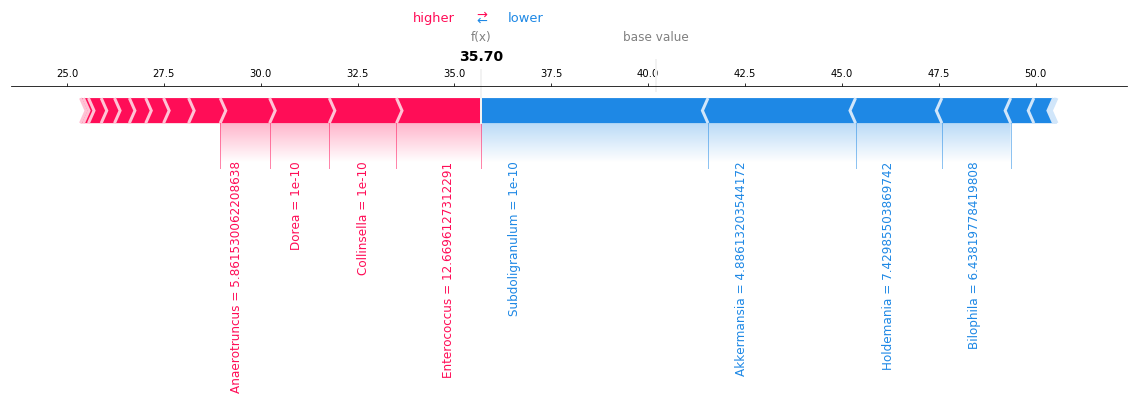


--- Intervention bacteria ---

Subdoligranulum
before = 1e-10
after = 1e-10

Enterococcus
before = 12.6696127312291
after = 12.8318853716863

Dorea
before = 1e-10
after = 1e-10

Akkermansia
before = 4.88613203544172
after = 6.577318654435645

Lactococcus
before = 8.012025868807
after = 7.698546042515271

Anaerotruncus
before = 5.861530062208638
after = 4.26166757006989

Collinsella
before = 1e-10
after = 1e-10

Eubacterium
before = 8.012025868807
after = 8.19432813559928

Faecalibacterium
before = 1e-10
after = 1e-10

Anaerostipes
before = 4.88613203544172
after = 1e-10

Bilophila
before = 6.43819778419808
after = 7.697979290972735

Prevotella
before = 5.861530062208638
after = 4.359987413703935

Holdemania
before = 7.42985503869742
after = 5.2905574848312344

Sutterella
before = 4.88613203544172
after = 1e-10

Bryantella
before = 1e-10
after = 1e-10

Enterobacter
before = 1e-10
after = 1e-10

Anaerovorax
before = 1e-10
after = 5.185852845748231

Clostridium
before = 1e-10
after = 1e-

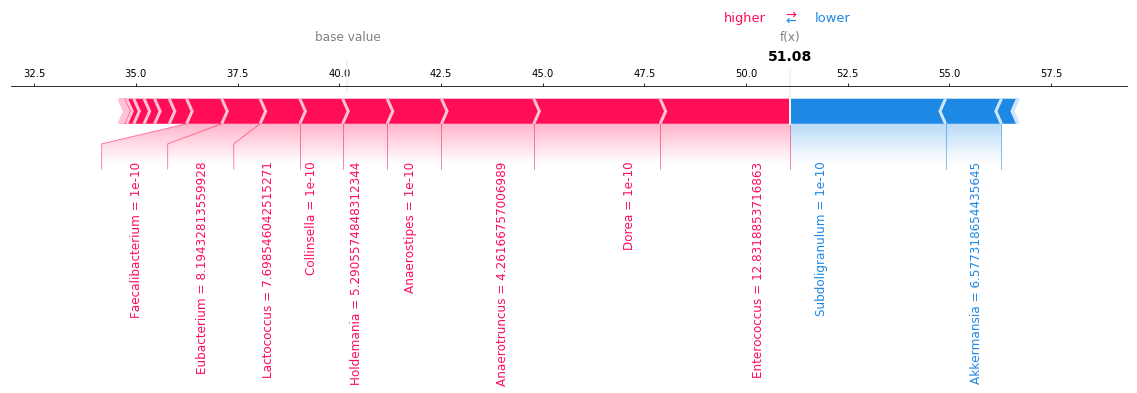

In [97]:
_val = outlier_intervention(outlier_sampleID=outlier_sampleID, estimator=estimator, df_all=val1, feature_columns=feature_cols, nice_name=lambda x: x[3:], max_num_bacterias_to_change=20, traj_x=traj_x, traj_mean=traj_mean, traj_pi=traj_pi, time_unit_size=1, time_unit_name="days", 
                            file_name=f"{PIPELINE_DIRECTORY}/outlier1.csv", output_html=False, plot=True, normal_vals=[True, False], average=np.median, std=np.std)



In [98]:
fig, traj_x, traj_pi, traj_mean = plot_importance_boxplots_over_age(estimator, df_all=val1, top_bacteria=feature_cols, nice_name=lambda x: x[3:], units=[20, 20], df_new=_val, time_unit_size=1, time_unit_name="days", box_height=15, 
                                  plateau_area_start=None, longitudinal_mode="markers", limit_age=70, PI_percentage=90, dtick=5, layout_settings=dict(font=dict(size=20)), highlight_outliers=[outlier_sampleID]);

In [62]:
feature_cols = topK_important_features(10, estimator, df, feature_cols=feature_cols, n_splits=n_splits, estimator_for_fit=rfr, save=True, file_name=f'{PIPELINE_DIRECTORY}/important_features.txt')

In [63]:
X_train1, y_train1 = df2vectors(train1, feature_cols)
X_val1, y_val1     = df2vectors(val1, feature_cols)
X_train2, y_train2 = df2vectors(train2, feature_cols)
X_val2, y_val2     = df2vectors(val2, feature_cols)

In [64]:
rfr = Regressor(**parameters)
gkf = list(GroupKFold(n_splits=n_splits).split(X_train1, y_train1, groups=train1["subjectID"].values))

search = GridSearchCV(rfr, param_grid, cv=gkf)
search.fit(X_train1, y_train1)

estimator = search.best_estimator_
estimator.save_model(f"{PIPELINE_DIRECTORY}/model_NoTopImportant")

In [65]:
from microbiome.trajectory import *

In [66]:
val1["diet_BK"].dtype

dtype('O')

In [67]:
plot_trajectory(estimator=estimator, df=val1, feature_cols=feature_cols, df_other=None, group="diet_BK", nonlinear_difference=True, start_age=0, limit_age=70, plateau_area_start=45);

../../microbiome/statistical_analysis.py:174: RankWarning:

Polyfit may be poorly conditioned

../../microbiome/statistical_analysis.py:174: RankWarning:

Polyfit may be poorly conditioned



In [68]:
plot_trajectory(estimator=estimator, df=val1, feature_cols=feature_cols, df_other=None, group="diet_BK", linear_difference=True, start_age=0, limit_age=70, plateau_area_start=45);

In [69]:
plot_trajectory(estimator=estimator, df=val1, feature_cols=feature_cols, df_other=val2, group=None, start_age=0, limit_age=70, plateau_area_start=45);

In [70]:
plot_trajectory(estimator=estimator, df=val1, feature_cols=feature_cols, df_other=None, group="diet_BK", start_age=0, limit_age=70, plateau_area_start=45);

In [71]:
plot_trajectory(estimator=estimator, df=val1, feature_cols=feature_cols, df_other=None, time_unit_size=30, time_unit_name="months", group="diet_BK", start_age=0, limit_age=85, plateau_area_start=45);

### Same model (trained on reference) on different datasets (ref dataset vs. other dataset)

In [72]:
#from elmtoolbox.trajectory import plot_2_trajectories

In [73]:
plot_2_trajectories(estimator, val1, val2, feature_cols, degree=2, plateau_area_start=45, limit_age=70, start_age=0, time_unit_size=1, time_unit_name="days", linear_pval=True, nonlinear_pval=False, img_file_name=None, )

In [74]:
plot_2_trajectories(estimator, val1, val2, feature_cols, degree=2, plateau_area_start=45, limit_age=70, start_age=0, time_unit_size=1, time_unit_name="days", linear_pval=False, nonlinear_pval=True, img_file_name=None)

In [75]:
plot_2_trajectories(estimator, val1, val2, feature_cols, degree=2, plateau_area_start=45, limit_age=70, start_age=0, time_unit_size=30, time_unit_name="months", linear_pval=False, nonlinear_pval=True, img_file_name=None)

In [76]:
from microbiome.data_analysis import *

In [77]:
plot_importance_boxplots_over_age(estimator, df_all=val1, top_bacteria=feature_cols, nice_name=lambda x: x[3:], units=[20, 20, 20], df_new=None, time_unit_size=30, time_unit_name="months", box_height=1, plateau_area_start=70, longitudinal_mode="markers");

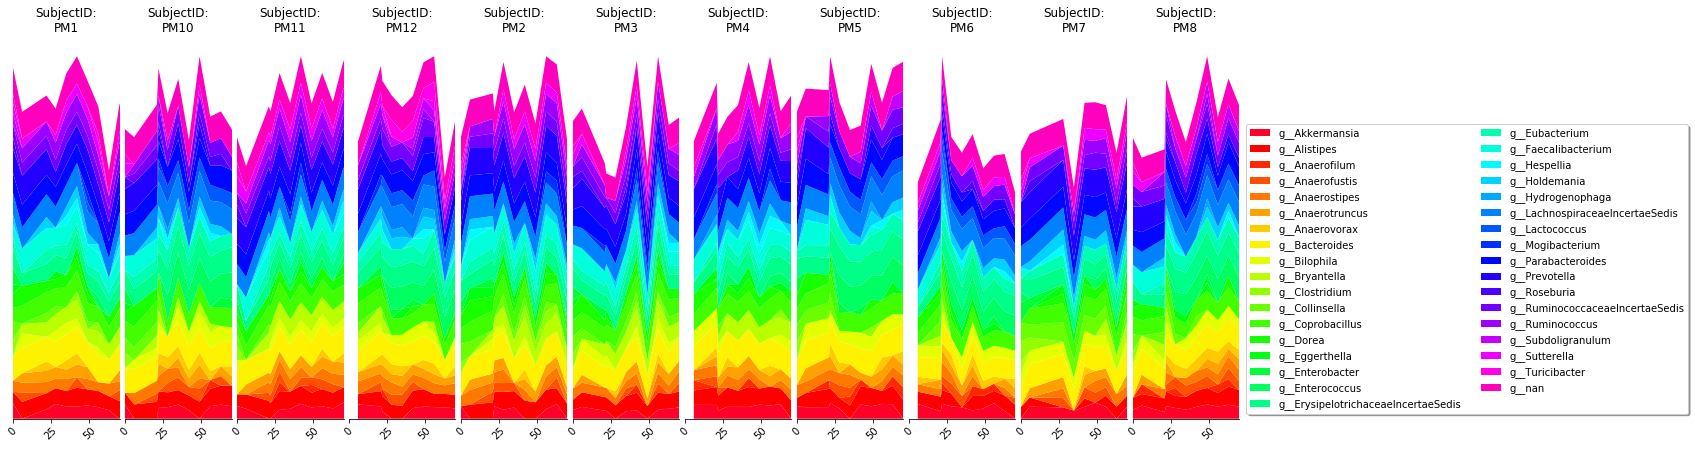

In [78]:
plot_ultradense_longitudinal_data_matplotlib(df, infants_to_plot=df.subjectID.unique(), cols_num=15, min_days=0, max_days=70, bacteria_names=bacteria_names, legend_kw=dict(bbox_to_anchor=(1.02, 0.), ncol=2, loc='lower left', fancybox=True, shadow=True))

In [79]:
plot_ultradense_longitudinal_data(df, infants_to_plot=df.subjectID.unique(), cols_num=15, min_days=0, max_days=70, bacteria_names=bacteria_names, file_name = "tst.html", h=600)